
# Applying Temporal Convonotional Networks to the Virtual Flow Metering Problem 

## Author: Ridha Alkhabaz 

### Imports:

In [447]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [535]:
# for tcn applications
import numpy as np
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, RepeatVector
from tensorflow.keras.preprocessing import sequence
from tcn import TCN, compiled_tcn
import tensorflow as tf
import os
os.chdir("/Users/ridhaalkhabaz/Documents/GitHub/ElectricDemandForecasting-DL/src/")
from models import tcn
# for data configurations
import sys
import zipfile
from dateutil.parser import parse
import json
from random import shuffle
import random
import datetime
import math
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot, dates
from datetime import timedelta
from pandas import read_csv
from pandas import datetime
from numpy import array
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import datetime as dttm

### Data configuration and Reading:

#### First: Riser data:

##### Reading the data and formating:

In [536]:
# Convert the sequence of seconds into datetime array
def parser(x):
    now_seconds = 0
    y = x.astype(np.float) + now_seconds
    z = pd.to_datetime(y, unit='s')
    return z

In [603]:
# Read the data from fname and eventually plot them
def read_data(fname, plot_data = False):
    # Read the time series
    datats = read_csv(fname, header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

    headers = list(datats.columns.values)
    headers.insert(0, datats.index.name)

    # Resample the data using a uniform timestep
    datats = datats.resample('S').mean()
    datats = datats.interpolate(method='linear')
    # Convert data to numpy array
    data = datats.reset_index().values

    # Replace timestamps with seconds
    time_sec = array([data[i, 0].timestamp() for i in range(len(data))])
    data = np.c_[time_sec, data[:, 1:]]
    
    # some outliers and spikes
#     for i in random.sample(range(1, 3000), 100):
#         data[i][1:] = random.sample(range(1, 3000), 9)
        
    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(data)
    scaler.scale_[0] = 1    # Do not normalize time

    # Apply the same normalization to all pressure readings
    pind = list(range(1, 8))  # Indices of pressure readings
    pmin = scaler.data_min_[pind].min()
    pmax = scaler.data_max_[pind].max()
    scaler.scale_[pind] = ((scaler.feature_range[1] - scaler.feature_range[0]) / (pmax - pmin))
    scaler.min_[pind] = scaler.feature_range[0] - pmin * scaler.scale_[pind]

    data = scaler.transform(data)

    return data, scaler

##### Sliding window technique (Data configuration):

In [599]:
os.chdir("/Users/ridhaalkhabaz/Documents/GitHub/DeepAR_Prophet_VFM")
data_riser,scaler_riser= read_data('riser_pq_uni.csv')
df_riser = pd.DataFrame.from_dict(dict(zip(['ds', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7','gas(m3/day)', 'liquid(m3/day)' ], data.T)))
### previous readings of 
dt_gas_riser = np.array(df_riser['gas(m3/day)'])
dt_liquid_riser = np.array(df_riser['liquid(m3/day)'])
### gas and liquid datafram
df_gas_riser = df_riser.drop('liquid(m3/day)', axis=1)
df_gas_riser = df_gas_riser.set_index('ds')
df_liquid_riser = df_riser.drop('gas(m3/day)', axis=1)
df_liquid_riser = df_liquid_riser.set_index('ds')

###### Removing some values:

In [600]:
from random import randint
index = [randint(0, len(df_riser)) for i in range(100)]
df_riser.iloc[index,[1,2,3,4,5,6, 7, 8, 9]] = 0

###### Adding some gaussian noise:

In [601]:
df_riser = df_riser.set_index('ds')
mu, sigma = 0, 5e-3
noise = np.random.normal(mu, sigma, df_riser.shape)
df_riser = df_riser + noise

###### Some visualization for the data:

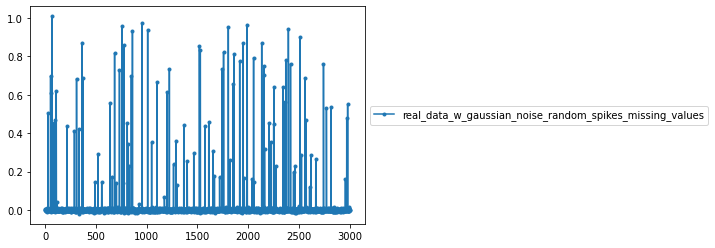

In [602]:
df_riser = df_riser.reset_index()
fig,ax = plt.subplots()
ax.plot(df_riser['ds'], df_riser['gas(m3/day)'], marker=".", label='real_data_w_gaussian_noise_random_spikes_missing_values')
ax.legend()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
df_riser = df_riser.set_index('ds')

##### Hyperparameters for the model:

In [576]:
# Model Hyperparemeters 
FORECAST_HORIZON = 1 #secs 
PAST_HISTORY = 300
BATCH_SIZE = 256
BUFFER_SIZE = 10000
EPOCHS = 30
METRICS = ['mse']

TCN_PARAMS = {
    'nb_filters': 128,
    'kernel_size': 3,
    'nb_stacks': 1,
    'dilations': [1, 2, 4, 8, 16, 32, 64],
    'dropout_rate': 0,
    'lr':0.001
}

In [571]:
# gas 
batch_size, timesteps, input_dim = 256, 300, 8
output_timesteps, output_dim = 1, 1


model2 = Sequential(
    layers=[
        TCN(input_shape=(timesteps, input_dim)),  # output.shape = (batch, 64)
        RepeatVector(output_timesteps),  # output.shape = (batch, output_timesteps, 64)
        Dense(output_dim)  # output.shape = (batch, output_timesteps, output_dim)
    ]
)

model2.summary()
model2.compile('adam', 'mse')

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn_41 (TCN)                 (None, 64)                138048    
_________________________________________________________________
repeat_vector_22 (RepeatVect (None, 1, 64)             0         
_________________________________________________________________
dense_72 (Dense)             (None, 1, 1)              65        
Total params: 138,113
Trainable params: 138,113
Non-trainable params: 0
_________________________________________________________________


#### Using only previous readings as an input:

In [554]:
def univariate_data(tseries, start_index, end_index, history_size, forecast_horizon, step=1, single_step=False):
    """
    Function to extract input-output windows from a time series
    :param tseries: time series array
    :param start_index: first value of the first x (input window)
    :param end_index: first value of the last y (output window)
    :param history_size: size of input window
    :param forecast_horizon: size of output prediction window
    :param step: sampling of time series for creating input windows
    :param single_step: single or multi-step prediction window
    :return: data (x), labels (y)
    """

    data = []
    labels = []

    start_index = start_index + history_size

    for i in range(start_index, end_index - forecast_horizon + 1):
        indices = range(i - history_size, i, step)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(tseries[indices], (history_size, 1)))

        if single_step:
            labels.append(tseries[i + forecast_horizon])
        else:
            labels.append(tseries[i:i + forecast_horizon])

    return np.array(data), np.array(labels)

In [583]:
## we are going to consider gas for now
x_uni, y_uni = univariate_data(dt_gas, 0, 2000, 300, 1, step=1, single_step=False)
valX_uni , valY_uni = univariate_data(dt_gas, 2000, 3000, 300, 1, step=1, single_step=False)
testX_riser_uni, testY_riser_uni = univariate_data(dt_gas,2500, 3000, 300, 1, step=1, single_step=False)
# to avoid combatibality issues
x_uni = x_uni.astype(np.float32)
y = y.astype(np.float32)
valX_uni = valX_uni.astype(np.float32)
valY = valY.astype(np.float32)
testX_riser_uni = testX_riser_uni.astype(np.float32)
testY_riser_uni = testY_riser_uni.astype(np.float32)

In [563]:
train_data_uni = tf.data.Dataset.from_tensor_slices((x, y)).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
val_data_uni = tf.data.Dataset.from_tensor_slices((valX, valY)).batch(BATCH_SIZE).repeat()

##### Using previous readings of pressure and flowrate:

In [556]:
def multivariate_data(tseries, start_index, end_index, history_size, forecast_horizon, step=1):
    data = []
    labels = []
    indices = []
    for i in range(start_index, end_index -history_size +1):
        end = i+history_size
        data.append(tseries[i:end, :])
        labels.append(tseries[end:end+1, -1])
        indices.append(end)

    return np.array(data), np.array(labels), indices

In [584]:
## we are going to consider the gas for now
x_mult, y_mult, _ = multivariate_data(np.array(df_gas_riser), 0, 2000, PAST_HISTORY, FORECAST_HORIZON, step=1)
valX_mult , valY_mult, _ = multivariate_data(np.array(df_gas_riser), 2000, 3000, PAST_HISTORY, FORECAST_HORIZON, step=1)
testX_riser_mult, testY_riser_mult, indices = multivariate_data(np.array(df_gas_riser), 2500, 3000, PAST_HISTORY, FORECAST_HORIZON, step=1)
# to avoid combatibility issues
x_mult = x_mult.astype(np.float32)
y_mult = y_mult.astype(np.float32)
valX_mult = valX_mult.astype(np.float32)
valY_mult = valY_mult.astype(np.float32)
testX_riser_mult = testX_riser_mult.astype(np.float32)
testY_riser_mult = testY_riser_mult.astype(np.float32)

In [585]:
train_data_mult = tf.data.Dataset.from_tensor_slices((x_mult, y_mult)).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
val_data_mult = tf.data.Dataset.from_tensor_slices((valX_mult, valY_mult)).batch(BATCH_SIZE).repeat()

##### Model fitting:

In [586]:
evaluation_interval = int(np.ceil(x_mult.shape[0] / BATCH_SIZE))
history = model2.fit(train_data_mult, epochs=200, steps_per_epoch=evaluation_interval, validation_data=val_data_mult, validation_steps=evaluation_interval)

Epoch 1/200
7/7 [==============================] - 10s 1s/step - loss: 8.1564e-05 - val_loss: 0.0309
Epoch 2/200
7/7 [==============================] - 10s 1s/step - loss: 7.6841e-05 - val_loss: 0.0310
Epoch 3/200
7/7 [==============================] - 10s 1s/step - loss: 7.3845e-05 - val_loss: 0.0310
Epoch 4/200
7/7 [==============================] - 10s 1s/step - loss: 6.9635e-05 - val_loss: 0.0310
Epoch 5/200
7/7 [==============================] - 10s 1s/step - loss: 6.6447e-05 - val_loss: 0.0310
Epoch 6/200
7/7 [==============================] - 10s 1s/step - loss: 6.3352e-05 - val_loss: 0.0311
Epoch 7/200
7/7 [==============================] - 10s 1s/step - loss: 6.0058e-05 - val_loss: 0.0311
Epoch 8/200
7/7 [==============================] - 10s 1s/step - loss: 5.7735e-05 - val_loss: 0.0311
Epoch 9/200
7/7 [==============================] - 10s 1s/step - loss: 5.4712e-05 - val_loss: 0.0311
Epoch 10/200
7/7 [==============================] - 10s 1s/step - loss: 5.2272e-05 - val_lo

7/7 [==============================] - 10s 1s/step - loss: 1.3206e-06 - val_loss: 0.0318
Epoch 82/200
7/7 [==============================] - 10s 1s/step - loss: 1.2710e-06 - val_loss: 0.0317
Epoch 83/200
7/7 [==============================] - 10s 1s/step - loss: 1.2019e-06 - val_loss: 0.0318
Epoch 84/200
7/7 [==============================] - 10s 1s/step - loss: 1.1404e-06 - val_loss: 0.0318
Epoch 85/200
7/7 [==============================] - 10s 1s/step - loss: 1.1169e-06 - val_loss: 0.0318
Epoch 86/200
7/7 [==============================] - 10s 1s/step - loss: 1.0649e-06 - val_loss: 0.0318
Epoch 87/200
7/7 [==============================] - 10s 1s/step - loss: 9.7261e-07 - val_loss: 0.0318
Epoch 88/200
7/7 [==============================] - 10s 1s/step - loss: 9.2020e-07 - val_loss: 0.0318
Epoch 89/200
7/7 [==============================] - 10s 1s/step - loss: 8.6435e-07 - val_loss: 0.0318
Epoch 90/200
7/7 [==============================] - 10s 1s/step - loss: 8.1759e-07 - val_loss: 

Epoch 161/200
7/7 [==============================] - 10s 1s/step - loss: 1.6519e-05 - val_loss: 0.0319
Epoch 162/200
7/7 [==============================] - 10s 1s/step - loss: 2.5034e-05 - val_loss: 0.0319
Epoch 163/200
7/7 [==============================] - 10s 1s/step - loss: 2.3602e-05 - val_loss: 0.0318
Epoch 164/200
7/7 [==============================] - 10s 1s/step - loss: 3.0053e-05 - val_loss: 0.0319
Epoch 165/200
7/7 [==============================] - 10s 1s/step - loss: 3.5887e-05 - val_loss: 0.0317
Epoch 166/200
7/7 [==============================] - 11s 2s/step - loss: 3.7689e-05 - val_loss: 0.0321
Epoch 167/200
7/7 [==============================] - 10s 2s/step - loss: 3.7080e-05 - val_loss: 0.0319
Epoch 168/200
7/7 [==============================] - 13s 2s/step - loss: 3.2612e-05 - val_loss: 0.0318
Epoch 169/200
7/7 [==============================] - 11s 2s/step - loss: 3.2932e-05 - val_loss: 0.0317
Epoch 170/200
7/7 [==============================] - 10s 1s/step - loss: 

##### Parameters for model fitness:

In [587]:
mean_squared_error(model2.predict(testX_riser_mult).flatten(), testY_riser_mult.flatten())

0.018368922

In [507]:
mean_squared_error(model2.predict(testX_riser).flatten(), testY_riser.flatten())

6.80297e-05

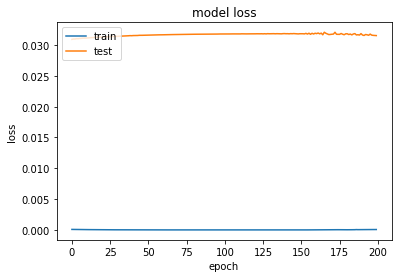

In [588]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [589]:
real1 = testY_riser_mult.flatten()
pred1 = model2.predict(testX_riser_mult).flatten()

In [591]:
dfy=pd.DataFrame.from_dict(dict(zip(['prediction', 'real' ], np.array([pred1, real1]))))
dfy['ds']=range(0,201)

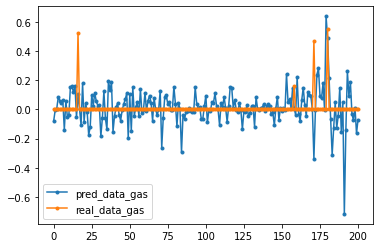

In [592]:
fig,ax = plt.subplots()
ax.plot(dfy['ds'], dfy['prediction'], marker=".", label='pred_data_gas')
ax.plot(dfy['ds'], dfy['real'], marker=".", label='real_data_gas')
ax.legend()

In [509]:
real = testY_riser.flatten()
pred = model2.predict(testX_riser).flatten()

In [510]:
# real = testY_riser.reshape(941)
# pred = dt_pred = model2.predict(testX_riser).reshape(941)
dfx=pd.DataFrame.from_dict(dict(zip(['prediction', 'real' ], np.array([pred, real]))))
dfx['ds']=range(0,701)

##### Trying to predict using out TCN model:

In [392]:
dt_pred = model2.predict(testX_riser)
df_pred = pd.DataFrame.from_dict(dict(zip(['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7','gas(m3/day)', 'liquid(m3/day)' ], dt_pred.T)))
df_pred['ds'] = range(1560, 2001)

ValueError: If using all scalar values, you must pass an index

In [ ]:
# dft = dft.reset_index()
# larger tcn layer and larger FCN layer 
# larger training horizen 
fig,ax = plt.subplots()
ax.plot(dfx['ds'], dfx['prediction'], marker=".", label='pred_data_gas_multi')
ax.plot(dfx['ds'], dfx['real'], marker=".", label='real_data_gas')
ax.legend()

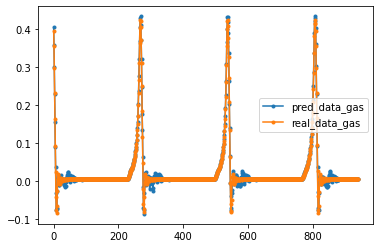

In [436]:
fig,ax = plt.subplots()
ax.plot(dfx['ds'], dfx['prediction'], marker=".", label='pred_data_gas')
ax.plot(dfx['ds'], dfx['real'], marker=".", label='real_data_gas')
ax.legend()

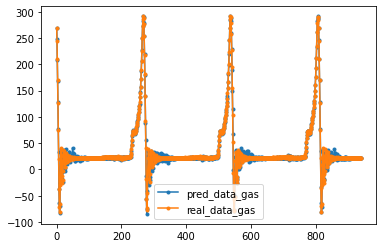

In [446]:
fig,ax = plt.subplots()
ax.plot(dfx['ds'], dfx['prediction'], marker=".", label='pred_data_gas')
ax.plot(dfx['ds'], dfx['real'], marker=".", label='real_data_gas')
ax.legend()

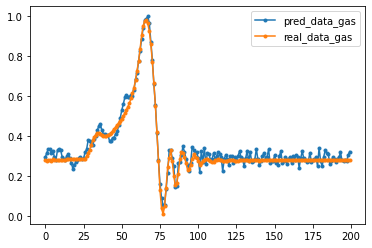

In [482]:
fig,ax = plt.subplots()
ax.plot(dfx['ds'], dfx['prediction'], marker=".", label='pred_data_gas')
ax.plot(dfx['ds'], dfx['real'], marker=".", label='real_data_gas')
ax.legend()

##### The well dataset 

In [283]:
def read_data(fname, plot_data = False):
    # Read the time series
    datats = read_csv(fname, header=0, dayfirst=True, parse_dates=[0], index_col=0, squeeze=True)  # , date_parser=parser

    headers = list(datats.columns.values)
    headers.insert(0, datats.index.name)

    # Convert data to numpy array
    data = datats.reset_index().values

    # Split data into flow periods, and resample each flow period using a uniform timestep
    dt = np.ediff1d(data[:, 0])
    fpbreak = dttm.timedelta(hours=1)  # Minimal break between flow periods
    dt = dt - fpbreak
    ind = np.where(dt - fpbreak > pd.Timedelta(0))[0]
    ind = np.r_[ind, len(data)-1]

    Nfp = len(ind)  # Number of flow periods
    fp = ['None'] * Nfp
    n0 = 0
    n1 = ind[0]+1
    for n in range(Nfp):
        # Resample each flow period separately
        fpts = datats[n0:n1].resample('T').mean()
        fpts = fpts.interpolate(method='linear')
        # Save the resampled flow period to a list of numpy arrays
        fp[n] = fpts.reset_index().values
        #fp[n] = data[n0:n1,:]
        n0 = n1
        if n+1 < Nfp:
            n1 = ind[n+1] + 1
    # some outliers and spikes
    for i in random.sample(range(1, 3000), 100):
        data[i][1:] = random.sample(range(1, 3000), 5)

    # Get the normalization parameters for all data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(data[:,1:]) # Exclude Datetime from normalization

    # Normalize every flow period
    for n in range(Nfp):
        fp[n][:,1:] = scaler.transform(fp[n][:,1:])

    return fp, headers, scaler

In [272]:
# some trials 
# os.chdir("/Users/ridhaalkhabaz/Documents/GitHub/DeepAR_Prophet_VFM")
# fp, headers = read_data('welltest.csv')
# df = pd.DataFrame.from_dict(dict(zip(headers, fp[0].T)))
# for i in [1,2,3, 4]:
#     tmp = pd.DataFrame.from_dict(dict(zip(headers, fp[i].T)))
#     df = pd.concat([df,tmp], axis=0)
# df =  df.set_index('DateTime')

In [284]:
os.chdir("/Users/ridhaalkhabaz/Documents/GitHub/DeepAR_Prophet_VFM")
fp, headers, scaler = read_data('welltest.csv')
df = pd.DataFrame.from_dict(dict(zip(headers, fp[0].T)))
for i in [1,2,3, 4]:
    tmp = pd.DataFrame.from_dict(dict(zip(headers, fp[i].T)))
    df = pd.concat([df,tmp], axis=0)
df =  df.set_index('DateTime')
## adding some gaussian noise 
mu, sigma = 0, 5e-4
noise = np.random.normal(mu, sigma, df.shape)
df = df + noise
## removing some values 
df = df.reset_index()
from random import randint
index = [randint(0, len(df)) for i in range(100)]
df.iloc[index,[1,2,3,4,5]] = 0

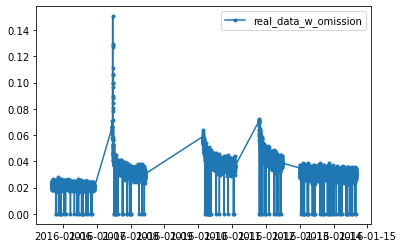

In [285]:
fig,ax = plt.subplots()
ax.plot(df['DateTime'], df['Qo (m3/day)'], marker=".", label='real_data_w_omission')
ax.legend()
df =  df.set_index('DateTime')

In [286]:
def multivariate_data(tseries, start_index, end_index, history_size, forecast_horizon, step=1):
    data = []
    labels = []
    for i in range(start_index, end_index -history_size +1):
        end = i+history_size
        data.append(tseries[i:end, :])
        labels.append(tseries[end:end+1, :])

    return np.asarray(data), np.asarray(labels)

In [287]:
train = np.array(df.iloc[:int(len(df)*0.7)])
test = np.array(df.iloc[int(len(df)*0.7):])

In [292]:
FORECAST_HORIZON = 30 #secs 
PAST_HISTORY = 60
BATCH_SIZE = 256
BUFFER_SIZE = 10000
EPOCHS = 100
METRICS = ['mse']


TCN_PARAM = {
    'nb_filters': 128,
    'kernel_size': 3,
    'nb_stacks': 1,
    'dilations': [1, 2, 4, 8, 16, 32, 64],
    'dropout_rate': 0,
    'lr':0.001
}
x_train, y_train = multivariate_data(train, 0, 2500, PAST_HISTORY, FORECAST_HORIZON, step=1)
valX , valY = multivariate_data(train, 2500, 4000, PAST_HISTORY, FORECAST_HORIZON, step=1)
testX, testY = multivariate_data(train, 4000, 5500, PAST_HISTORY, FORECAST_HORIZON, step=1)
x_train = x_train.astype(np.float32)
y_train = y_train.astype(np.float32)
valX = valX.astype(np.float32)
valY = valY.astype(np.float32)
testX = testX.astype(np.float32)
testY = testY.astype(np.float32)

In [293]:
mod = tcn(x_train.shape, 5, 'adam', 'mse', 
            nb_filters=TCN_PARAM['nb_filters'],
            kernel_size=TCN_PARAM['kernel_size'],
            nb_stacks= TCN_PARAM['nb_stacks'],
            dilations=TCN_PARAM['dilations'],
            dropout_rate=TCN_PARAM['dropout_rate'])
mod.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 60, 5)]           0         
_________________________________________________________________
tcn_15 (TCN)                 (None, 128)               643456    
_________________________________________________________________
flatten_15 (Flatten)         (None, 128)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 5)                 645       
_________________________________________________________________
dense_31 (Dense)             (None, 5)                 30        
Total params: 644,131
Trainable params: 644,131
Non-trainable params: 0
_________________________________________________________________


In [294]:
traindt = tf.data.Dataset.from_tensor_slices((x_train, y_train)).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
valdt = tf.data.Dataset.from_tensor_slices((valX, valY)).batch(BATCH_SIZE).repeat()


In [295]:
evaluationInterval = int(np.ceil(x_train.shape[0] / BATCH_SIZE))
mod.fit(traindt, epochs=EPOCHS, steps_per_epoch=evaluationInterval, validation_data=valdt, validation_steps=evaluationInterval)

Epoch 1/100
10/10 [==============================] - 14s 1s/step - loss: 8343.1701 - val_loss: 1175.0396
Epoch 2/100
10/10 [==============================] - 12s 1s/step - loss: 270.9399 - val_loss: 151.2963
Epoch 3/100
10/10 [==============================] - 12s 1s/step - loss: 71.9882 - val_loss: 60.1370
Epoch 4/100
10/10 [==============================] - 12s 1s/step - loss: 24.4429 - val_loss: 25.0226
Epoch 5/100
10/10 [==============================] - 12s 1s/step - loss: 10.2314 - val_loss: 7.8338
Epoch 6/100
10/10 [==============================] - 12s 1s/step - loss: 3.6420 - val_loss: 2.8318
Epoch 7/100
10/10 [==============================] - 12s 1s/step - loss: 1.6087 - val_loss: 2.7531
Epoch 8/100
10/10 [==============================] - 12s 1s/step - loss: 1.1930 - val_loss: 2.8017
Epoch 9/100
10/10 [==============================] - 12s 1s/step - loss: 1.1176 - val_loss: 2.3429
Epoch 10/100
10/10 [==============================] - 12s 1s/step - loss: 1.0272 - val_loss: 2

Epoch 83/100
10/10 [==============================] - 12s 1s/step - loss: 0.0868 - val_loss: 0.2000
Epoch 84/100
10/10 [==============================] - 12s 1s/step - loss: 0.0871 - val_loss: 0.1943
Epoch 85/100
10/10 [==============================] - 12s 1s/step - loss: 0.0841 - val_loss: 0.1904
Epoch 86/100
10/10 [==============================] - 12s 1s/step - loss: 0.0824 - val_loss: 0.1876
Epoch 87/100
10/10 [==============================] - 13s 1s/step - loss: 0.0791 - val_loss: 0.1810
Epoch 88/100
10/10 [==============================] - 12s 1s/step - loss: 0.0770 - val_loss: 0.1785
Epoch 89/100
10/10 [==============================] - 12s 1s/step - loss: 0.0804 - val_loss: 0.1767
Epoch 90/100
10/10 [==============================] - 12s 1s/step - loss: 0.0765 - val_loss: 0.1708
Epoch 91/100
10/10 [==============================] - 12s 1s/step - loss: 0.0758 - val_loss: 0.1726
Epoch 92/100
10/10 [==============================] - 12s 1s/step - loss: 0.0760 - val_loss: 0.1627


In [296]:
mean_squared_error(mod.predict(testX).flatten(), testY.flatten())

0.1563769

In [256]:
scaler.inverse_transform(testY.reshape((1441, 5)))

array([[1.0535014e+02, 4.6515411e+01, 1.6192332e+02, 7.8471513e+00,
        6.3507169e+05],
       [1.0510802e+02, 4.7306973e+01, 1.6340407e+02, 7.7131171e+00,
        6.3530950e+05],
       [1.0677398e+02, 4.4357563e+01, 1.5147099e+02, 8.8440418e+00,
        6.4168975e+05],
       ...,
       [1.0573511e+02, 5.0959854e+01, 1.6047675e+02, 1.1800814e+01,
        6.7132144e+05],
       [1.0715128e+02, 5.1332207e+01, 1.5103326e+02, 1.1924137e+01,
        6.7527044e+05],
       [1.0554124e+02, 4.8362049e+01, 1.6077882e+02, 7.0849857e+00,
        6.7198919e+05]], dtype=float32)

In [297]:
dfy.iloc[4043:]

,Pressure (bar),Temperature (degC),Qo (m3/day),Qw (m3/day),Qg (m3/day)
DateTime,,,,,
2016-01-10 17:24:00,105.579935,45.509997,165.056745,8.558246,635140.0802
2016-01-10 17:25:00,105.005054,46.168698,155.95656,7.937328,640229.8728
2016-01-10 17:26:00,105.044443,45.643879,167.214961,8.093444,634300.4434
2016-01-10 17:27:00,105.162395,45.449422,171.494107,8.751078,632200.1964
2016-01-10 17:28:00,104.66845,46.295829,169.9894,8.631732,632509.5771
...,...,...,...,...,...
2016-01-14 15:53:00,103.495278,44.544447,133.559008,6.193034,547369.7314
2016-01-14 15:54:00,103.117811,44.657796,132.912958,6.100417,548060.0912
2016-01-14 15:55:00,102.913494,44.199496,144.886085,6.66888,542190.24


In [298]:
dfReal = pd.DataFrame.from_dict(dict(zip(['p', 't', 'Qo', 'Qw', 'Qg' ],testY.reshape((1441, 5)).T)))
dfReal = dfReal. reset_index()
dfReal

,index,p,t,Qo,Qw,Qg
0,0,0.033541,0.015284,0.038531,0.003224,0.706637
1,1,0.033874,0.015858,0.039260,0.003185,0.705905
2,2,0.034462,0.016034,0.035879,0.003405,0.712783
3,3,0.033847,0.015229,0.039071,0.003283,0.707581
4,4,0.033756,0.015914,0.036897,0.002587,0.710361
...,...,...,...,...,...,...
1436,1436,0.033721,0.015841,0.036277,0.003478,0.749078
1437,1437,0.034565,0.016092,0.039270,0.004797,0.743222
1438,1438,0.034656,0.015018,0.038172,0.003343,0.748008
1439,1439,0.034251,0.016755,0.035976,0.002418,0.753554


In [299]:
pred_dt = mod.predict(testX)
dfPred = pd.DataFrame.from_dict(dict(zip(['p', 't', 'Qo', 'Qw', 'Qg' ], pred_dt.T)))
dfPred = dfPred.reset_index()

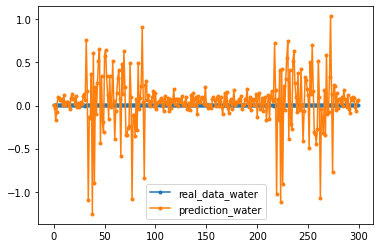

In [311]:
fig,ax = plt.subplots()
# ax.plot(dfReal['index'], dfReal['Qo'], marker=".", label='real_data_oil')
# ax.plot(dfPred['index'], dfPred['Qo'], marker=".", label='prediction_oil')
ax.plot(dfReal['index'].iloc[:300], dfReal['Qw'].iloc[:300], marker=".", label='real_data_water')
ax.plot(dfPred['index'].iloc[:300], dfPred['Qw'].iloc[:300], marker=".", label='prediction_water')
# ax.plot(dfReal['index'], dfReal['Qg'], marker=".", label='real_data_gas')
# ax.plot(dfPred['index'], dfPred['Qg'], marker=".", label='prediction_gas')
ax.legend()

In [306]:
mean_squared_error(dfReal.iloc[:, 3:6], dfPred.iloc[:, 3:6])

0.18745637

In [305]:
dfReal.iloc[:, 3:6]

,Qo,Qw,Qg
0,0.038531,0.003224,0.706637
1,0.039260,0.003185,0.705905
2,0.035879,0.003405,0.712783
3,0.039071,0.003283,0.707581
4,0.036897,0.002587,0.710361
...,...,...,...
1436,0.036277,0.003478,0.749078
1437,0.039270,0.004797,0.743222
1438,0.038172,0.003343,0.748008
1439,0.035976,0.002418,0.753554


#### Training of our proposed model:

In [ ]:
mse_list = []
for x in range(1):
    model = Sequential(
        layers=[
            compiled_tcn(return_sequences=False,
                         num_feat=10,
                         nb_filters=24,
                         num_classes=0,
                         kernel_size=8,
                         dilations=[2 ** i for i in range(9)],
                         nb_stacks=2,
                         max_len=30,
                         lr=0.001,
                         use_skip_connections=False,
                         regression=False,
                         dropout_rate=0,
                         output_len= 30),
            RepeatVector(1),  # output.shape = (batch, output_timesteps, 64)
            Dense(2)  # output.shape = (batch, output_timesteps, output_dim)
        ]
        )
    model.compile('adam', 'mse')
    model.fit(train_x,train_y,batch_size=64,epochs=1)
    y_pred = model.predict(np.array([test_x]))
    print(y_pred)
    print(test_y)
#     mse_cur = mean_squared_error(y_pred,test_y)
#     mse_list.append(mse_cur)
#     print(f"train_set_size:{train_x.shape[0]}")
#     print(f"y_true:{test_y}")
#     print(f"y_pred:{y_pred}")
#     print(f"mse:{mse_cur}")
# print(np.mean(mse_list))

In [ ]:
#### extra 
# only flow rates - seperate models - conov kerneal among other hyperparameters 

model = tcn(x.shape, 9, 'adam', 'mse', 
            nb_filters=TCN_PARAMS['nb_filters'],
            kernel_size=TCN_PARAMS['kernel_size'],
            nb_stacks= TCN_PARAMS['nb_stacks'],
            dilations=TCN_PARAMS['dilations'],
            dropout_rate=TCN_PARAMS['dropout_rate'])
model.summary()